# Импортируем нужные библиотеки

In [221]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import missingno as msno

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline

# EDA

In [222]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
df.shape

(8693, 14)

In [ ]:
df['Transported'].value_counts()

Transported
True     4378
False    4315
Name: count, dtype: int64

Видим что классы сбалансированы, значит можем использовать accuracy.

Заменим true и false на 1 и 0 соответственно

In [223]:
df[['Transported', 'CryoSleep', 'VIP']] = df[['Transported', 'CryoSleep', 'VIP']].apply(lambda col: col.map(lambda x: 1 if x is True else (0 if x is False else x)))

In [ ]:
df['Transported'].value_counts()

Transported
1    4378
0    4315
Name: count, dtype: int64

Посмотрим на категориальные и числовые признаки

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Transported   8693 non-null   int64  
dtypes: float64(6), int64(1), object(5)
memory usage: 815.1+ KB


In [ ]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,0.503624
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.500016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000


In [ ]:
df.describe(include='object')

,HomePlanet,CryoSleep,Cabin,Destination,VIP
count,8492,8476,8494,8511,8490
unique,3,2,6560,3,2
top,Earth,False,G/734/S,TRAPPIST-1e,False
freq,4602,5439,8,5915,8291


Теперь займемся обработкой пропусков

In [ ]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

<Axes: >

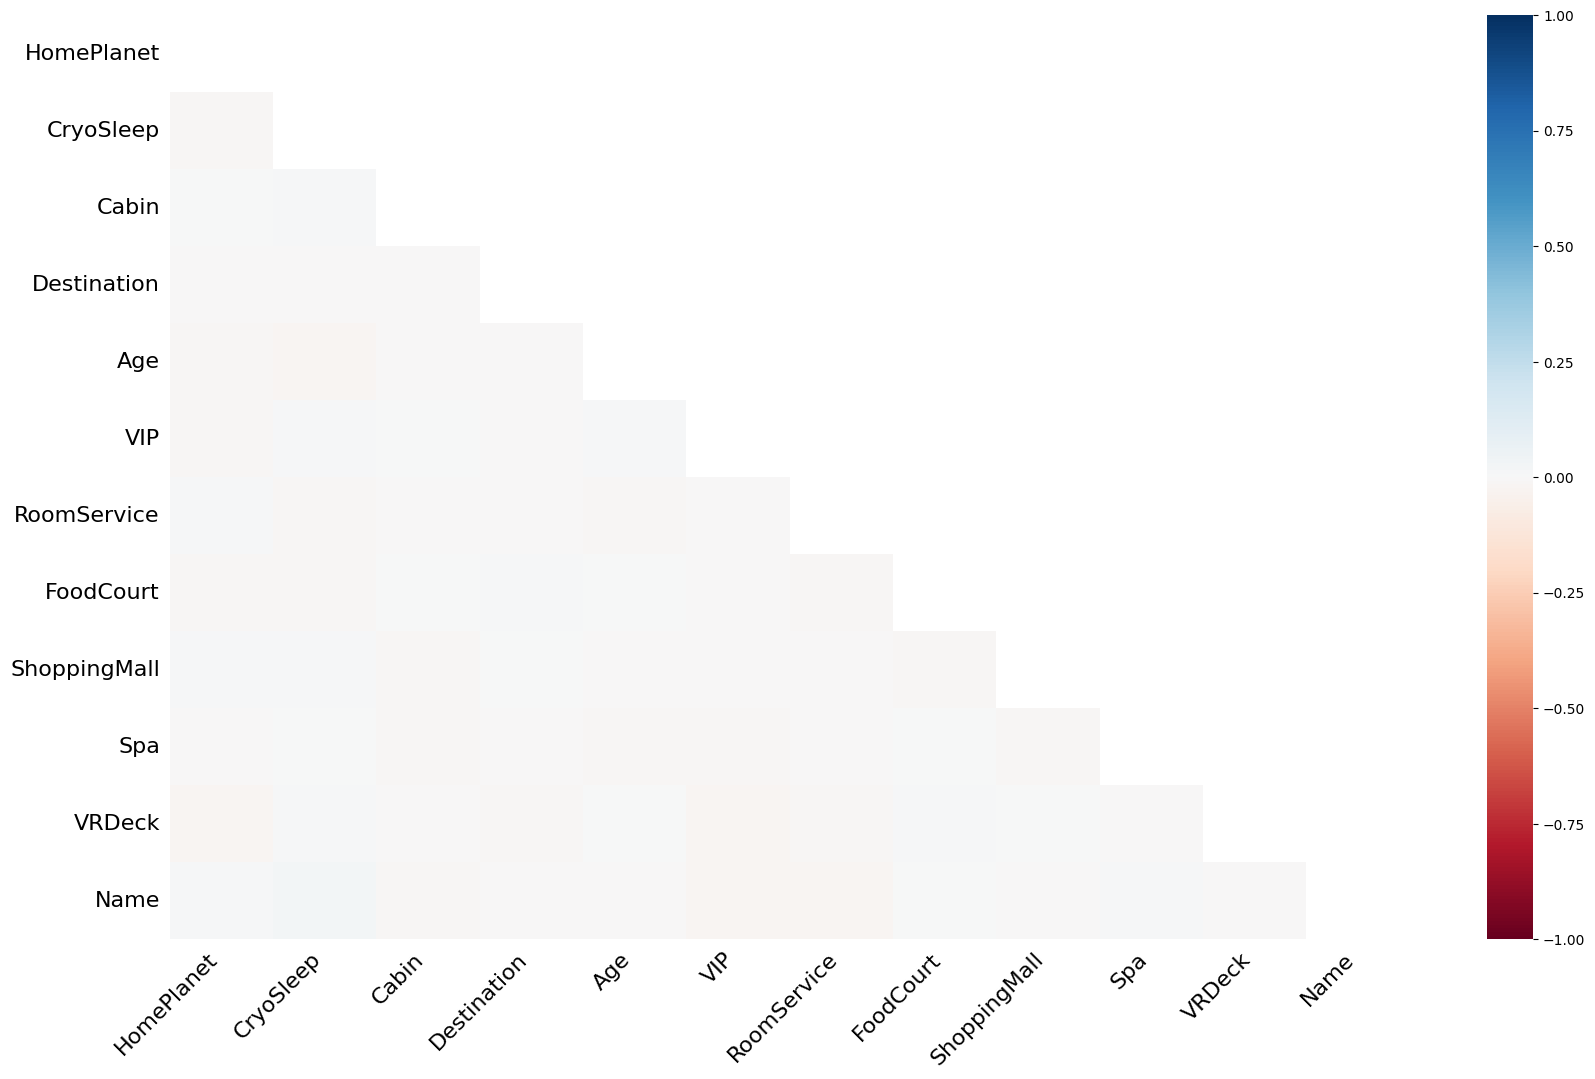

In [ ]:
msno.heatmap(df)


Видим, что пропуски никак не коррелируют между собой, значит можем использовать стандартные методы их заполнения. Теперь посмотрим на них детальнее

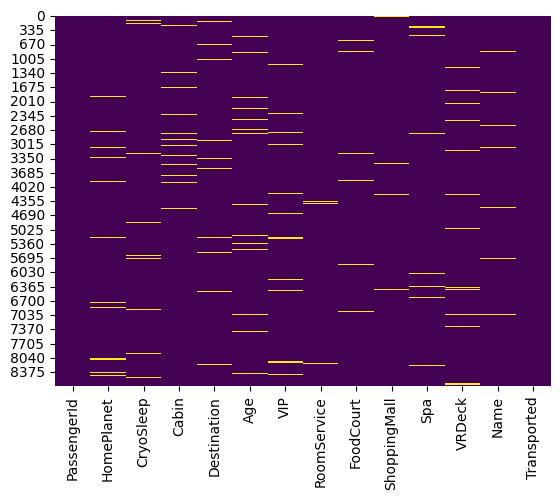

In [ ]:

sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()

Итак по тепловой карте можем сделать предположение:
1) Пассажиры, которые находятся в криосне не совершали покупок в различных сервисах и как следствие пропуски у пассажиров, где CryoSleep == True мы должны заполнить 0.


In [ ]:
df[(df['CryoSleep'] == 1) & (df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]).isna().any(axis=1)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
7,0006_02,Earth,1.0,G/0/S,TRAPPIST-1e,28.0,0.0,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,1
10,0008_02,Europa,1.0,B/1/P,TRAPPIST-1e,34.0,0.0,0.0,0.0,NaN,0.0,0.0,Altardr Flatic,1
23,0020_03,Earth,1.0,E/0/S,55 Cancri e,29.0,0.0,0.0,0.0,NaN,0.0,0.0,Mollen Mcfaddennon,0
25,0020_05,Earth,1.0,E/0/S,PSO J318.5-22,1.0,0.0,NaN,0.0,0.0,0.0,0.0,Mael Brantuarez,0
28,0024_01,Europa,1.0,C/2/S,TRAPPIST-1e,62.0,0.0,0.0,0.0,NaN,0.0,0.0,Penton Fullided,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8600,9179_03,Earth,1.0,G/1494/P,PSO J318.5-22,18.0,0.0,0.0,0.0,NaN,0.0,0.0,Darley Tranciams,0
8607,9186_01,Mars,1.0,F/1878/P,TRAPPIST-1e,2.0,0.0,0.0,0.0,NaN,0.0,0.0,Mass Homin,1
8642,9221_01,Earth,1.0,G/1497/P,TRAPPIST-1e,21.0,0.0,0.0,0.0,0.0,0.0,NaN,Elicey Beachez,0
8643,9222_01,Mars,1.0,F/1784/S,TRAPPIST-1e,50.0,0.0,0.0,0.0,0.0,NaN,0.0,Carves Chate,1


Гипотеза верна как в одну так и вдругую сторону!


In [224]:
mask = (df['CryoSleep'] == 1) & (df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].isna().any(axis=1))

df.loc[mask, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = df.loc[mask, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0)

In [225]:
no_spending = (df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1) == 0)

df.loc[df["CryoSleep"].isnull(), "CryoSleep"] = no_spending[df["CryoSleep"].isnull()].astype(int)

Посмотрим распределение возраста и посмотрим на vip относительно него

<Axes: xlabel='Age', ylabel='Count'>

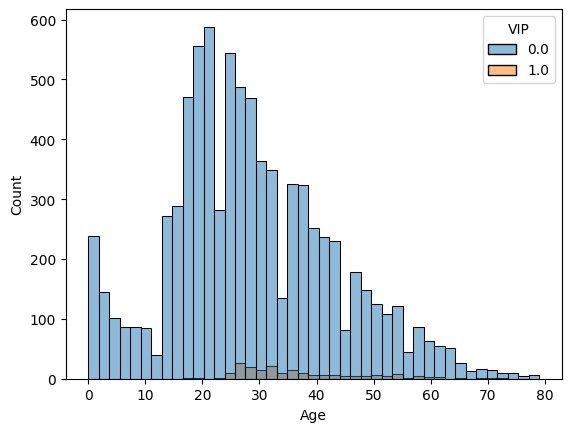

In [ ]:
sns.histplot(data=df, x='Age', hue='VIP')

In [ ]:
df['VIP'].value_counts()

VIP
0.0    8291
1.0     199
Name: count, dtype: int64

Мы видим, что распределение не является нормальным, а имеет правую скошенность, значит среднее значение > медианы => медианна предпочтительней, также посмотрим на vip: мы видим что доля не vip очень высокая => заполнять пропуски с помощью моделей бессмысленно при таком дисбалансе классов, самое логичное решение заполнить простой модой, а age заполним медианной по группе vip.

In [226]:
df['VIP'] = df['VIP'].fillna(0.0)

In [227]:
df['Age'] = df.groupby('VIP')['Age'].transform(lambda x: x.fillna(x.median()))

Проверим предположение, что  пассажиры из одиннаковых групп летят c/на одной и той же планеты.

In [228]:
df['№_of_group'], df['№_in_group'] = df['PassengerId'].apply(lambda x : x.split('_')[0]), df['PassengerId'].apply(lambda x : x.split('_')[1])

In [9]:
dest = df.groupby('№_of_group')['HomePlanet'].nunique()

print(f"Процент групп, где все люди с одной планеты: {(dest == 1).sum() / dest.shape[0] * 100}%")

Процент групп, где все люди с одной планеты: 98.23065787357245%


In [229]:
df['HomePlanet'] = df.groupby('№_of_group')['HomePlanet'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else df['HomePlanet'].mode()[0]))

df['Destination'] = df.groupby('№_of_group')['Destination'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else df['Destination'].mode()[0]))

Сделаем вывод, что почти все группы формируются на одной планете, но не все группы летят в одно место, часть людей могла менять маршрут.

In [ ]:
df.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           199
Destination       0
Age               0
VIP               0
RoomService     113
FoodCourt       113
ShoppingMall    112
Spa             118
VRDeck          126
Name            200
Transported       0
№_of_group        0
№_in_group        0
dtype: int64

Далее чтобы заполнить оставшиеся пропуски в колонках с тратами, посмотрим на распределение трат vip/no vip пассажиров

In [ ]:
vip_spending = df.groupby("VIP")[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].mean()
print(vip_spending)


     RoomService    FoodCourt  ShoppingMall         Spa       VRDeck
VIP                                                                 
0.0   217.076446   423.162175    170.028973  298.189209   280.969179
1.0   473.615385  1802.056701    247.726804  756.868687  1228.556122


In [ ]:
vip_spending = df.groupby("VIP")[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].max()
print(vip_spending)


     RoomService  FoodCourt  ShoppingMall      Spa   VRDeck
VIP                                                        
0.0      14327.0    27071.0       23492.0  22408.0  24133.0
1.0       8243.0    29813.0        3700.0  13902.0  12424.0


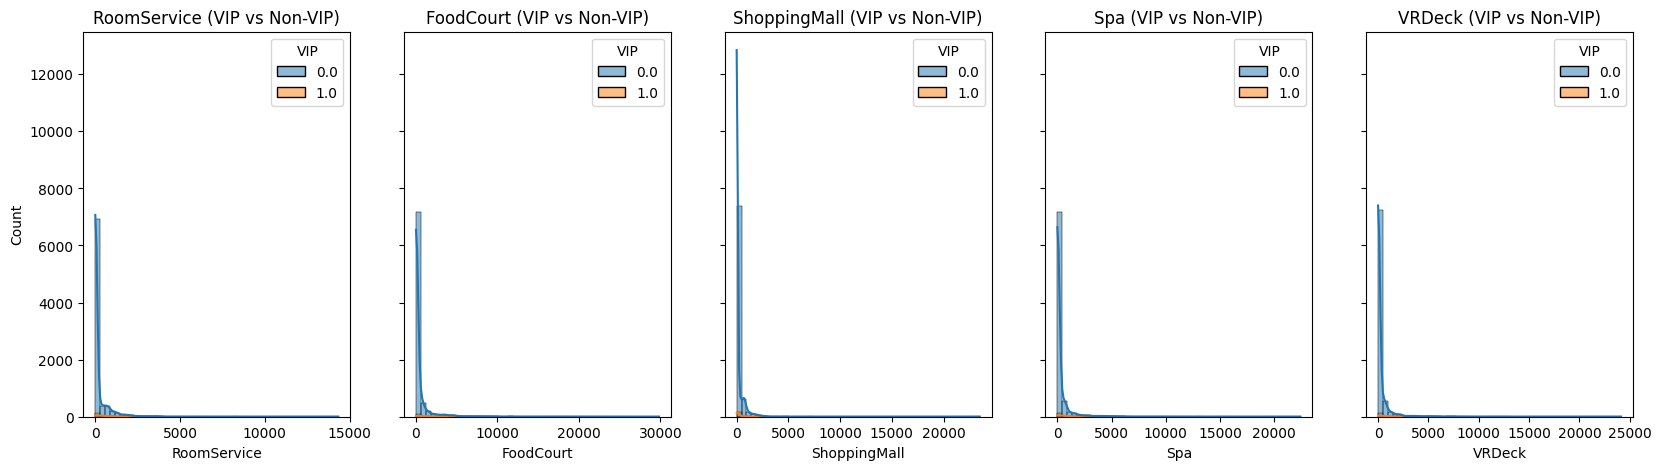

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

for i, col in enumerate(cols):
    sns.histplot(data=df, x=col, hue="VIP", bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"{col} (VIP vs Non-VIP)")

plt.show()


Итак мы видим, что траты как средние так и максимальные у vip персон логичные, а вот у no-vip есть выбросы, избавимся от них

In [230]:
vip_spending = df.groupby("VIP")[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].max().loc[1]

mask = (df["VIP"] == 0) & (
    (df["RoomService"] > vip_spending["RoomService"]) |
    (df["FoodCourt"] > vip_spending["FoodCourt"]) |
    (df["ShoppingMall"] > vip_spending["ShoppingMall"]) |
    (df["Spa"] > vip_spending["Spa"]) |
    (df["VRDeck"] > vip_spending["VRDeck"])
)

df = df[~mask]


In [ ]:
df.shape

(8637, 16)

In [ ]:
vip_spending = df.groupby("VIP")[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].max()
print(vip_spending)

     RoomService  FoodCourt  ShoppingMall      Spa   VRDeck
VIP                                                        
0.0       8209.0    27071.0        3700.0  13208.0  12392.0
1.0       8243.0    29813.0        3700.0  13902.0  12424.0


In [ ]:
vip_spending = df.groupby("VIP")[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].mean()
print(vip_spending)

     RoomService    FoodCourt  ShoppingMall         Spa       VRDeck
VIP                                                                 
0.0   213.197335   412.607370    144.482655  277.200913   260.423572
1.0   473.615385  1802.056701    247.726804  756.868687  1228.556122


In [231]:
columns = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

for col in columns:
    mean_vip = df.loc[df["VIP"] == 1, col].mean()
    median_non_vip = df.loc[df["VIP"] == 0, col].median()

    df.loc[(df["VIP"] == 1) & (df[col].isna()), col] = mean_vip
    df.loc[(df["VIP"] == 0) & (df[col].isna()), col] = median_non_vip

In [ ]:
df.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           198
Destination       0
Age             179
VIP             203
RoomService       2
FoodCourt         2
ShoppingMall      3
Spa               1
VRDeck            1
Name            198
Transported       0
№_of_group        0
№_in_group        0
dtype: int64

Теперь разберемся с Cabin

In [232]:
df['Deck'] = df['Cabin'].str.split('/').str[0]
df['Num'] = df['Cabin'].str.split('/').str[1]
df['Side'] = df['Cabin'].str.split('/').str[2]

deck_consistency = df.groupby('№_of_group')['Deck'].nunique(dropna=True)
side_consistency = df.groupby('№_of_group')['Side'].nunique(dropna=True)

print(f"Процент групп с одинаковым Deck: {(deck_consistency == 1).sum() / deck_consistency.shape[0] * 100}%")
print(f"Процент групп с одинаковым Side: {(side_consistency == 1).sum() / side_consistency.shape[0] * 100}%")

Процент групп с одинаковым Deck: 91.58455822968826%
Процент групп с одинаковым Side: 98.38475205944113%


Отлично! Можем сделать вывод, что  надо заполнить пропуски в Deck и Side на основе группы.

In [233]:
df['Deck'] = df.groupby('№_of_group')['Deck'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else df['Deck'].mode()[0])
)
df['Side'] = df.groupby('№_of_group')['Side'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else df['Side'].mode()[0])
)

deck_side_nums = df.groupby(['Deck', 'Side'])['Num'].apply(lambda x: x.dropna().unique()).to_dict()
df['Num'] = df.apply(
    lambda row: row['Num'] if pd.notna(row['Num']) else np.random.choice(
        deck_side_nums.get((row['Deck'], row['Side']), ['0'])
    ),
    axis=1
)

df['Num'] = pd.to_numeric(df['Num'], errors='coerce')

Отлично, пропуски мы заполнили и от выбросов избавились, детальнее анализируем признаки.

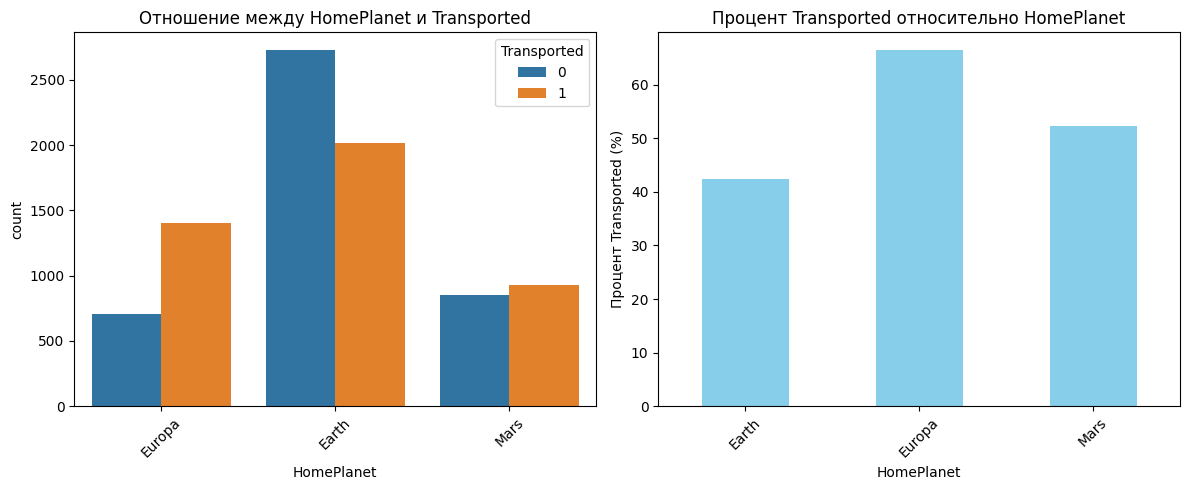

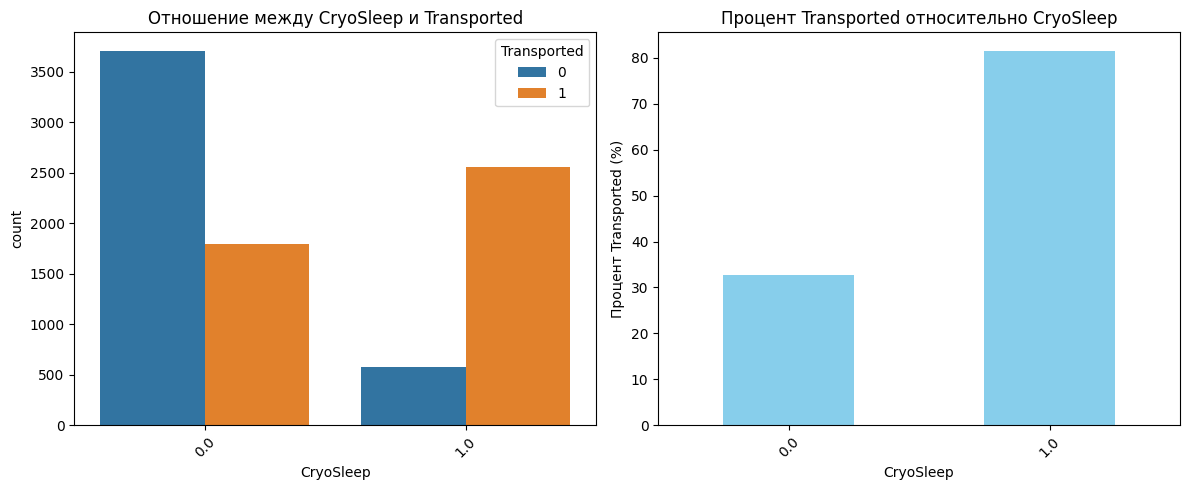

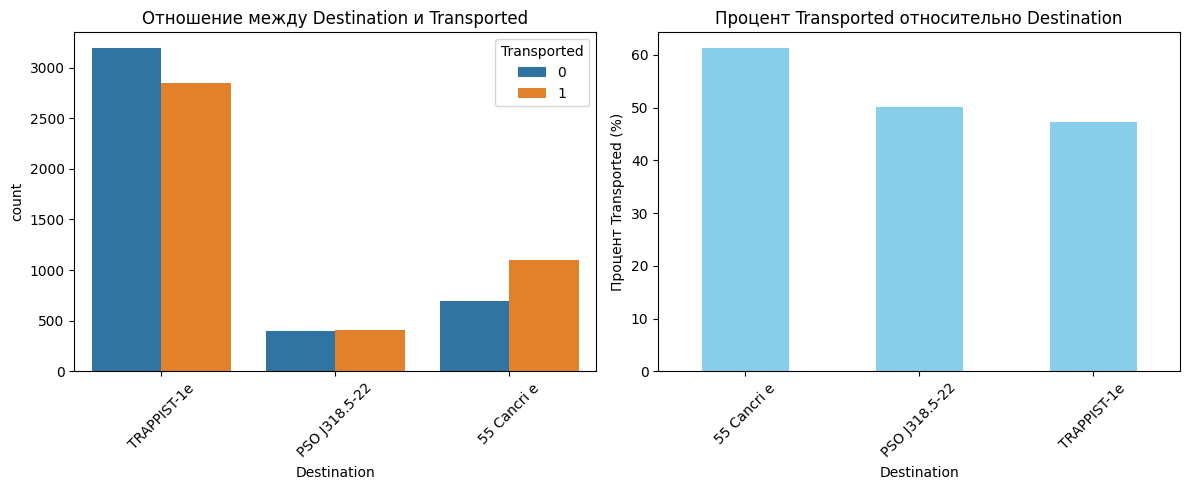

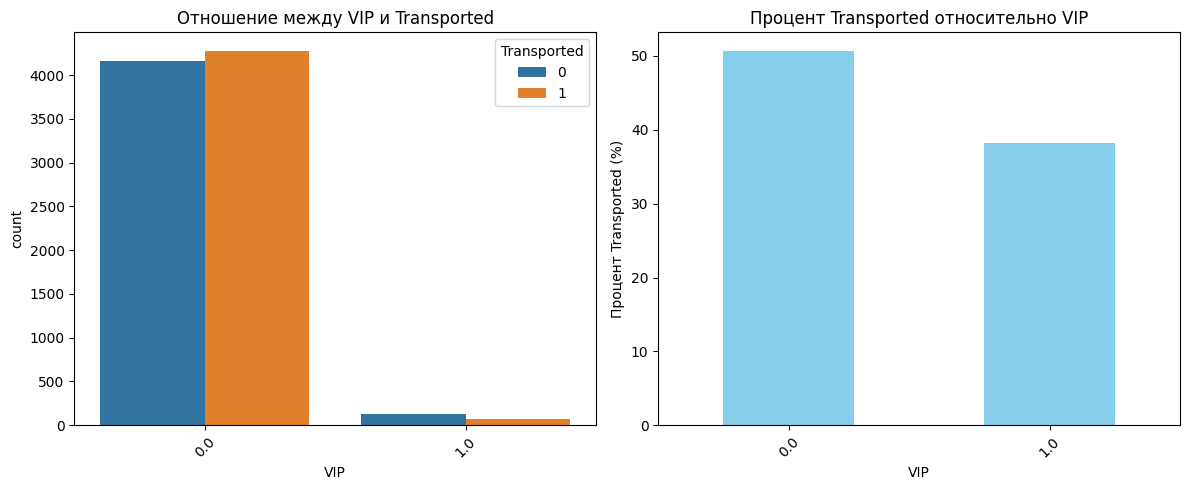

In [ ]:
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

for feature in categorical_features:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x=feature, hue='Transported', data=df)
    plt.title(f'Отношение между {feature} и Transported')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    transport_rate = df.groupby(feature)['Transported'].mean() * 100
    transport_rate.plot(kind='bar', color='skyblue')
    plt.title(f'Процент Transported относительно {feature}')
    plt.ylabel('Процент Transported (%)')
    plt.xticks(rotation=45)

    plt.tight_layout()

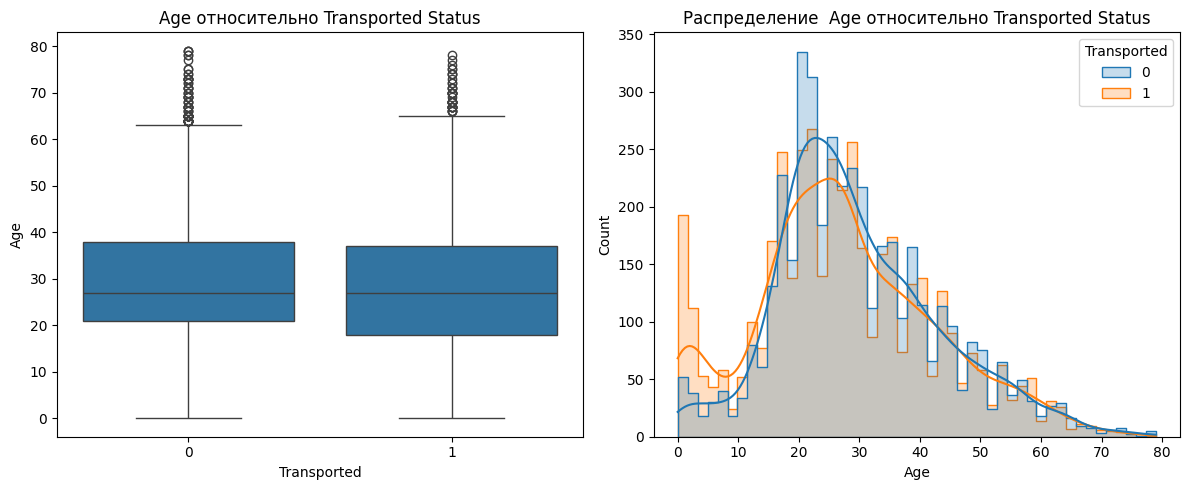

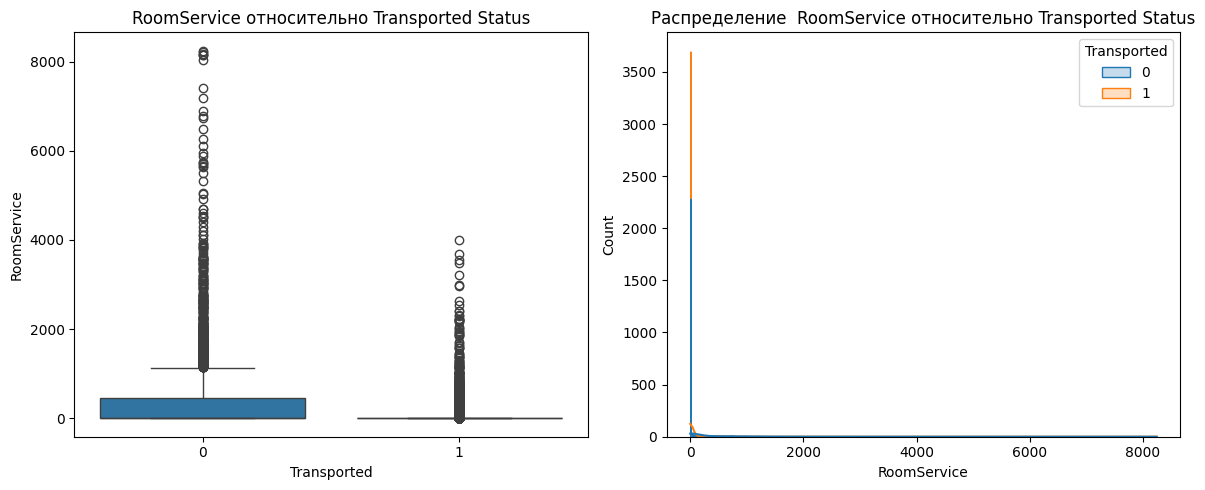

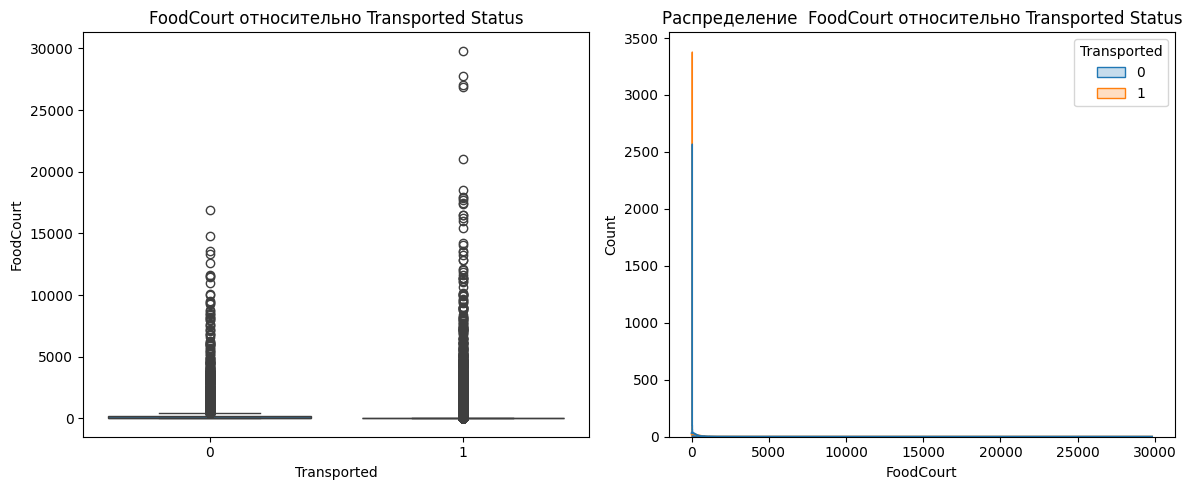

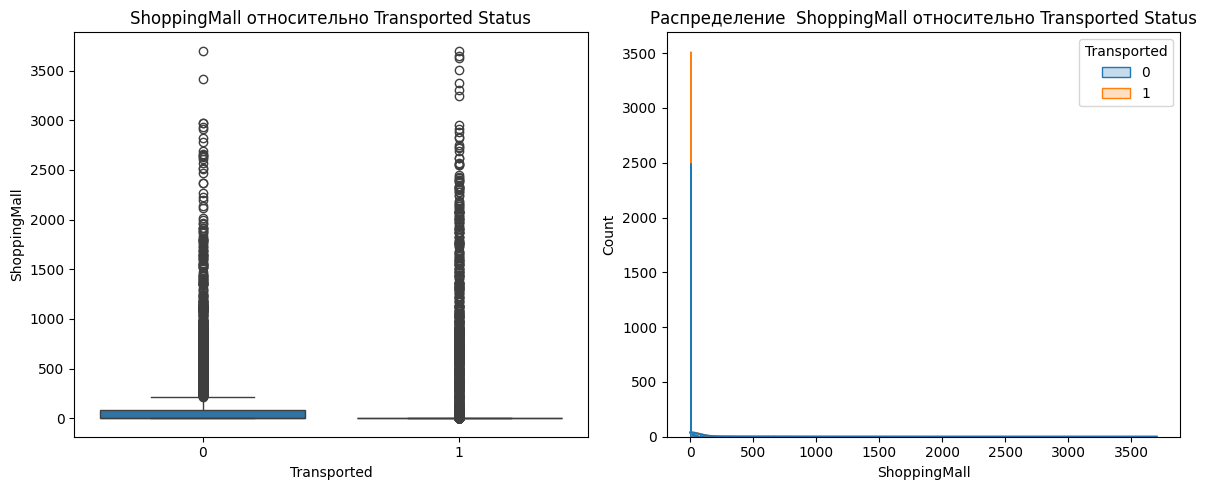

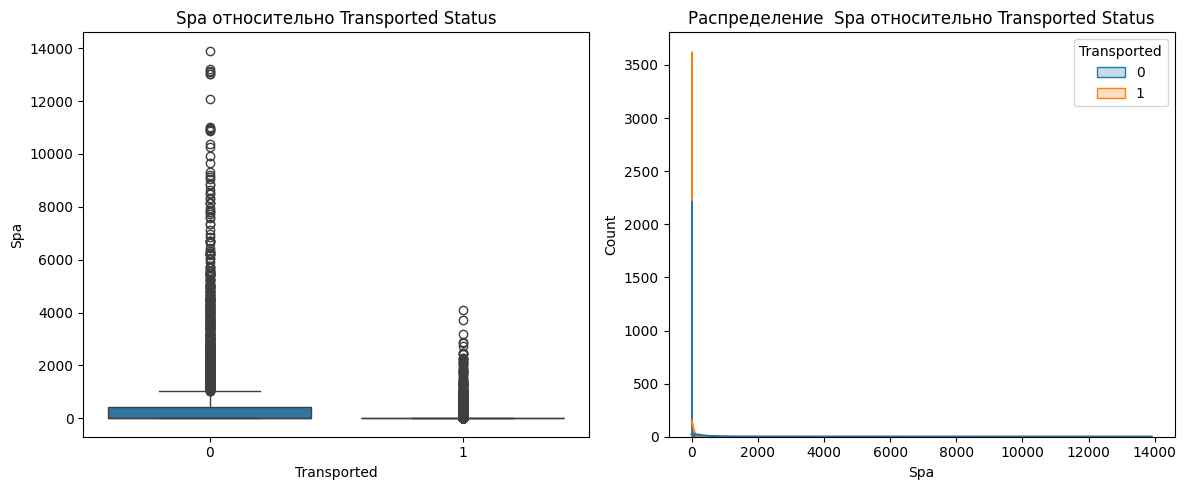

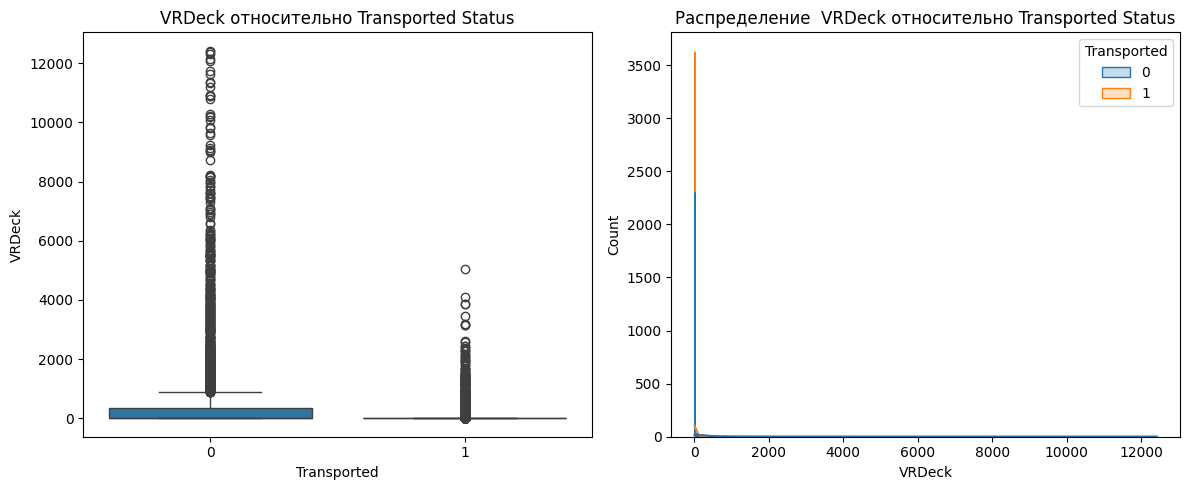

In [ ]:

numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for feature in numerical_features:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(x='Transported', y=feature, data=df)
    plt.title(f'{feature} относительно Transported Status')

    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x=feature, hue='Transported', element='step', kde=True, common_norm=False)
    plt.title(f'Распределение  {feature} относительно Transported Status')

    plt.tight_layout()

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'B'),
  Text(1, 0, 'F'),
  Text(2, 0, 'A'),
  Text(3, 0, 'G'),
  Text(4, 0, 'E'),
  Text(5, 0, 'D'),
  Text(6, 0, 'C'),
  Text(7, 0, 'T')])

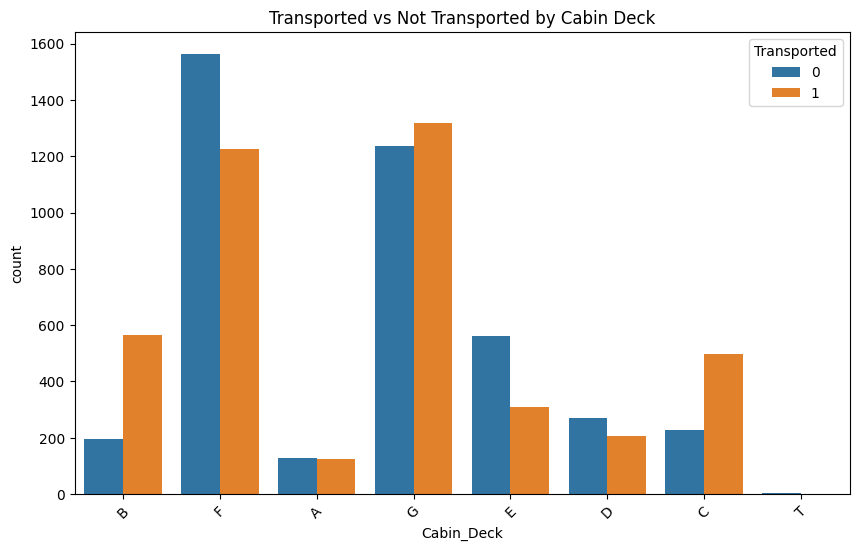

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Deck', hue='Transported', data=df)
plt.title('Transported vs Not Transported by Cabin Deck')
plt.xticks(rotation=45)

Text(0.5, 1.0, 'Correlation Matrix of Numerical Features')

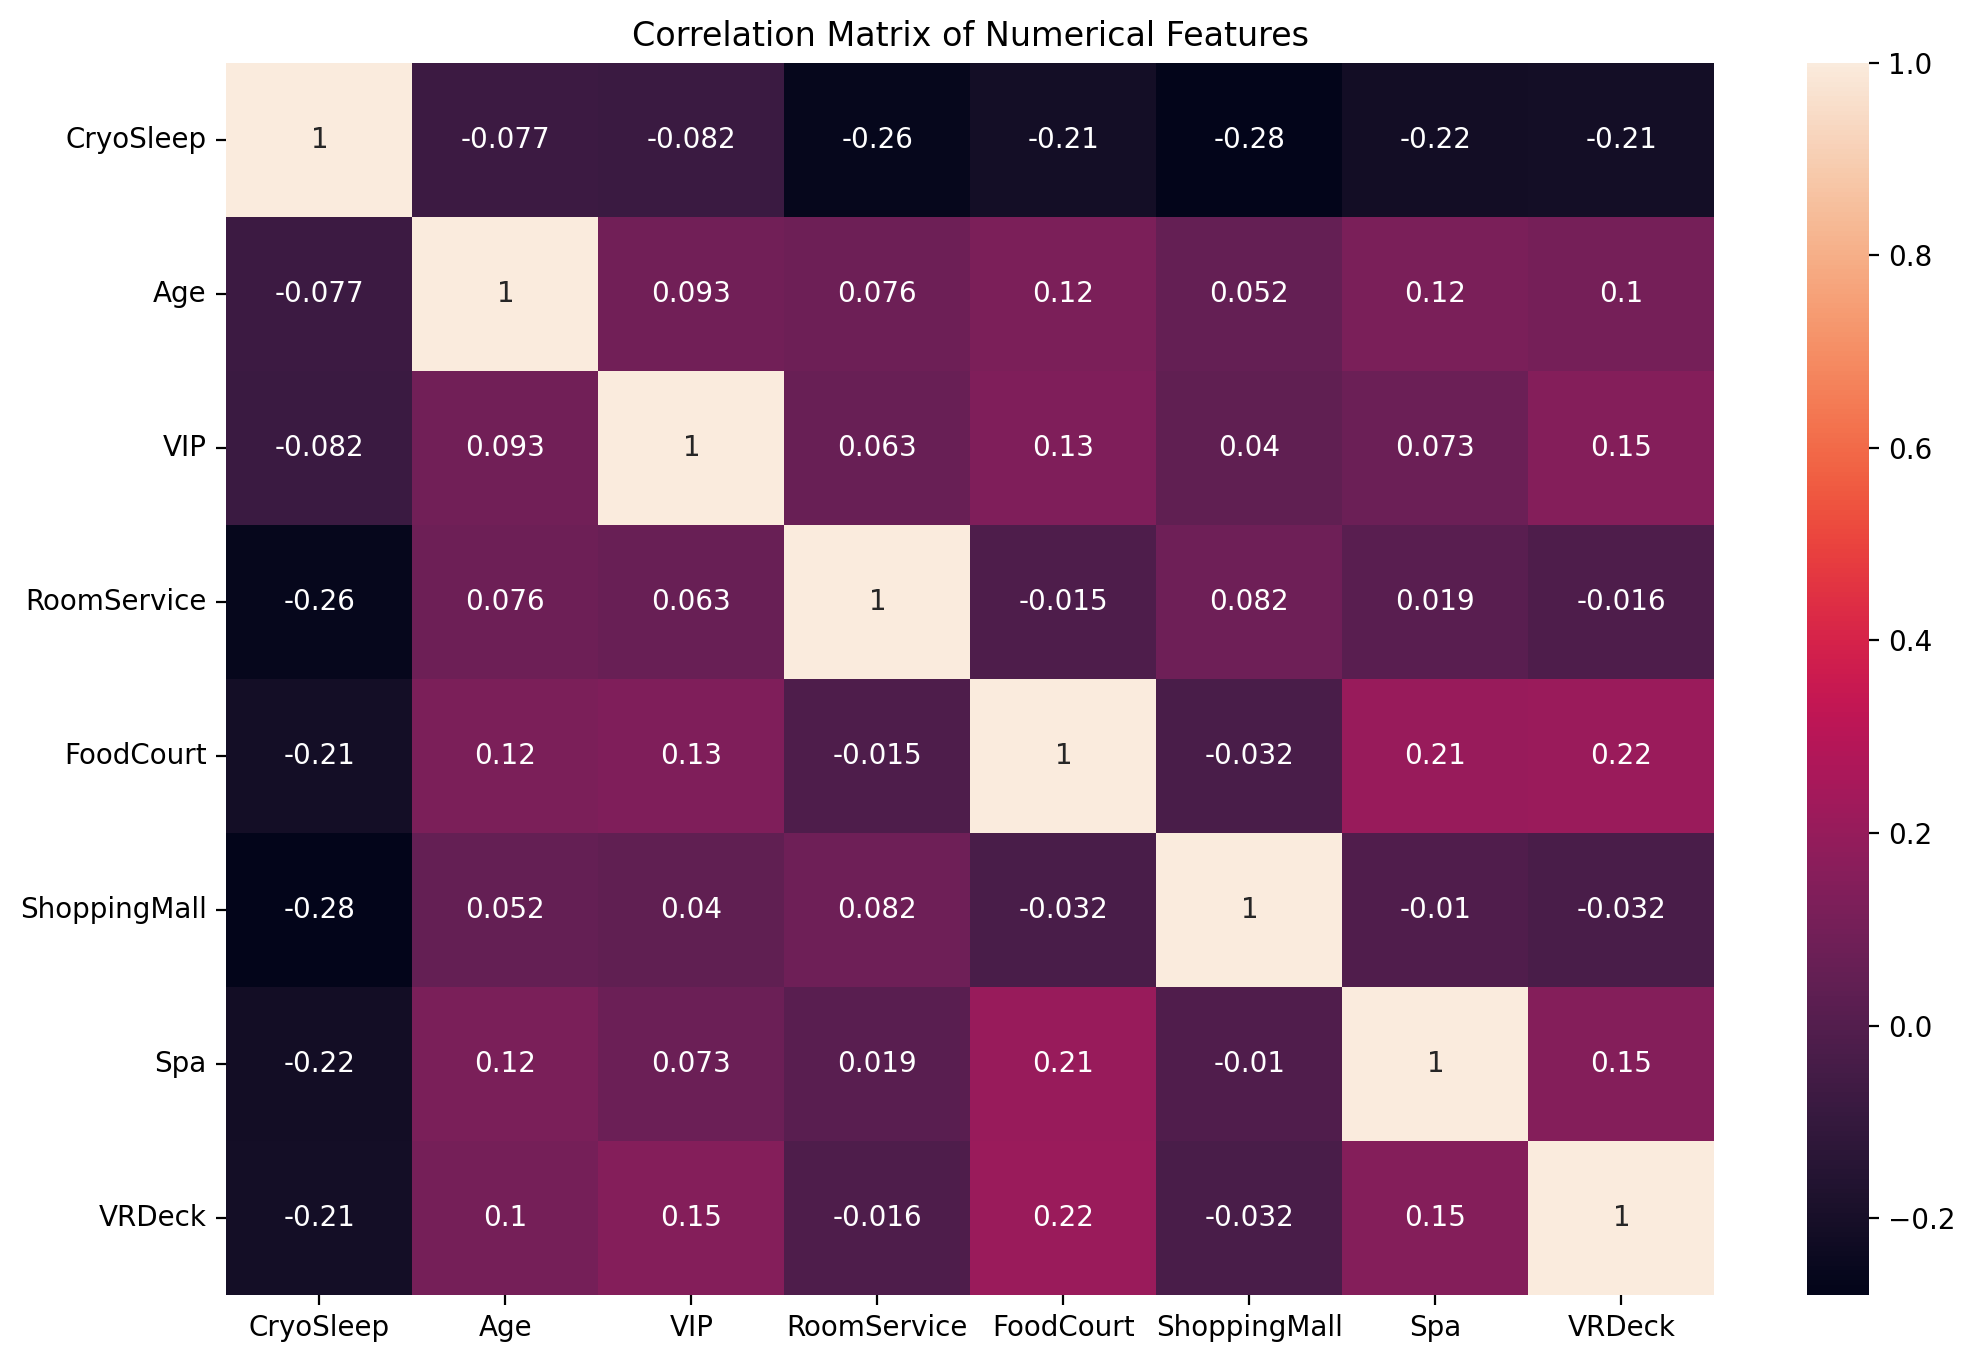

In [ ]:
plt.figure(figsize=(12, 8), dpi=200)
correlation_matrix = df[df.select_dtypes(include=float).columns].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix of Numerical Features')

Видим, что явной линейной зависимости между признаками нет, это замечательно.

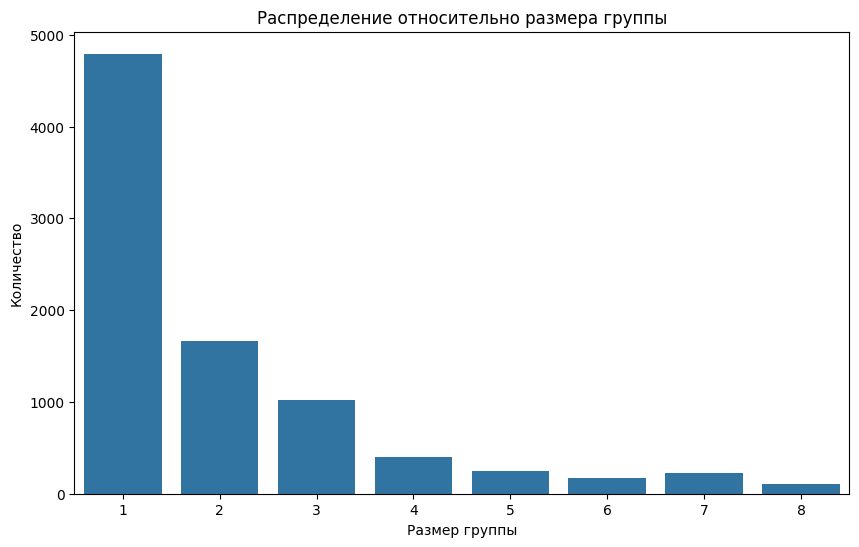

In [234]:
df['Group_Size'] = df.groupby('№_of_group')['№_in_group'].transform('count')

plt.figure(figsize=(10, 6))
sns.countplot(x='Group_Size', data=df, order=sorted(df['Group_Size'].unique()))
plt.title('Распределение относительно размера группы')
plt.xlabel('Размер группы')
plt.ylabel('Количество')
plt.show()

# Baseline

Теперь подготовим данные для обучения и сделаем baseline

Мы сделаем следующее:

1) Закодируем категориальные признаки с помощью TargetEncoder

2) масштабируем все числовые признаки с помощью StandardScaler

В качестве baseline будем использовать логистическую регрессию.

Удалим №_of_group, №_in_group так как они очевидно сильно коррелированы с размером группы

In [235]:
df = df.drop(['PassengerId', 'Cabin', '№_of_group', '№_in_group', 'Name'], axis=1)

In [236]:
X, y = df.drop('Transported', axis=1), df['Transported']

In [237]:
categorical_features = [col for col in X.columns if df[col].dtype == 'object' ]

numerical_features = [
    col for col in X.columns if col not in categorical_features]

numerical_features

['CryoSleep',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Num',
 'Group_Size']

In [238]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
enc = TargetEncoder(cols=categorical_features)

enc.fit(X_train, y_train)
X_train_new = enc.transform(X_train)
X_test_new = enc.transform(X_val)

scaler = StandardScaler()
scaler.fit(X_train_new)
X_train_new = pd.DataFrame(scaler.transform(X_train_new), columns=X_train.columns)
X_test_new = pd.DataFrame(scaler.transform(X_test_new), columns=X_val.columns)

model = LogisticRegression()
model.fit(X_train_new, y_train)
pred = model.predict(X_test_new)
predict_proba = model.predict_proba(X_test_new)[:, 1]

In [24]:
def print_metrics(predict, predict_proba, y_test):
    print({
        'accuracy' : accuracy_score(y_test, predict),
        'precision' : precision_score(y_test, predict),
        'recall' : recall_score(y_test, predict),
        'roc-auc' : roc_auc_score(y_test, predict_proba)
    })

In [25]:
print_metrics(pred, predict_proba, y_val)

{'accuracy': 0.7916666666666666, 'precision': 0.7858695652173913, 'recall': 0.8160270880361173, 'roc-auc': 0.8771199390894517}


Зафиксируем baseline метрики.

Далее попробуем создавать пайплайны с разными кодировщиками и их гиперпараметрами и скейлерами. После этого на лучшем из них будем подбирать гиперпараметры для логистической регрессии.

In [26]:
p2 = Pipeline([
    ('encoder_',TargetEncoder(cols=categorical_features, smoothing=1)),
    ('scaler_', StandardScaler()),
    ('model_', LogisticRegression())
    ])

p3 = Pipeline([
    ('encoder_',TargetEncoder(cols=categorical_features, smoothing=100)),
    ('scaler_', StandardScaler()),
    ('model_', LogisticRegression())
    ])

p4 = Pipeline([
    ('encoder_',TargetEncoder(cols=categorical_features, smoothing=1)),
    ('scaler_', MinMaxScaler()),
    ('model_', LogisticRegression())
    ])

p5 = Pipeline([
    ('encoder_',TargetEncoder(cols=categorical_features, smoothing=10)),
    ('scaler_', MinMaxScaler()),
    ('model_', LogisticRegression())
    ])

p6 = Pipeline([
    ('encoder_',TargetEncoder(cols=categorical_features, smoothing=100)),
    ('scaler_', MinMaxScaler()),
    ('model_', LogisticRegression())
    ])

p7 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=categorical_features)),
    ('scaler_', StandardScaler()),
    ('model_', LogisticRegression())
    ])

p8 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=categorical_features)),
    ('scaler_', MinMaxScaler()),
    ('model_', LogisticRegression())
    ])

In [27]:
for i,p in enumerate([p2,p3,p4,p5,p6,p7,p8]):
    p.fit(X_train, y_train)
    pred = p.predict(X_val)
    predict = p.predict_proba(X_val)[:, 1]
    print_metrics(pred,predict, y_val)
    print('\n')
    print(i)
    print('\n')

{'accuracy': 0.7916666666666666, 'precision': 0.7858695652173913, 'recall': 0.8160270880361173, 'roc-auc': 0.8771132367843949}


0


{'accuracy': 0.7916666666666666, 'precision': 0.7858695652173913, 'recall': 0.8160270880361173, 'roc-auc': 0.8771226200114742}


1


{'accuracy': 0.7800925925925926, 'precision': 0.8070388349514563, 'recall': 0.7505643340857788, 'roc-auc': 0.8672554865069193}


2


{'accuracy': 0.7800925925925926, 'precision': 0.8077858880778589, 'recall': 0.7494356659142212, 'roc-auc': 0.8672635292729876}


3


{'accuracy': 0.7795138888888888, 'precision': 0.8068043742405833, 'recall': 0.7494356659142212, 'roc-auc': 0.8672474437408514}


4


{'accuracy': 0.7916666666666666, 'precision': 0.7858695652173913, 'recall': 0.8160270880361173, 'roc-auc': 0.8771266413945084}


5


{'accuracy': 0.7800925925925926, 'precision': 0.8070388349514563, 'recall': 0.7505643340857788, 'roc-auc': 0.8671308236328639}


6




Улучшений метрик не видим. Попробуй подобрать гиперпараметры

In [28]:
p2 = Pipeline([
    ('encoder', TargetEncoder(cols=categorical_features, smoothing=1)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=2000))
])

param_grid = {
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__solver': ['liblinear', 'saga'],
    'model__class_weight': [None, 'balanced'],
}

grid_model = GridSearchCV(p2, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_model.fit(X_train, y_train)

print_metrics(grid_model.predict(X_val), grid_model.predict_proba(X_val)[:,1], y_val)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'accuracy': 0.7916666666666666, 'precision': 0.7858695652173913, 'recall': 0.8160270880361173, 'roc-auc': 0.877117258167429}


Хоть нам и не удалось поднять метрики, оценим важность признаков:

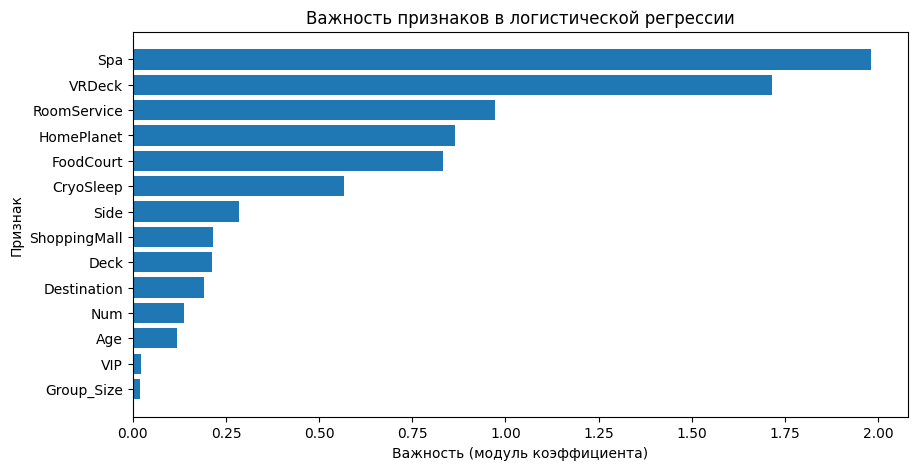

In [ ]:
feature_importance = grid_model.best_estimator_.named_steps['model'].coef_[0]

feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df['Abs_Importance'] = np.abs(importance_df['Importance'])
importance_df = importance_df.sort_values(by='Abs_Importance', ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(importance_df['Feature'], importance_df['Abs_Importance'])
plt.xlabel("Важность (модуль коэффициента)")
plt.ylabel("Признак")
plt.title("Важность признаков в логистической регрессии")
plt.gca().invert_yaxis()
plt.show()

Мы по этим результатам видим, что финансовое поведение пассажиров (расходы на Spa, VRDeck, RoomService) и их исходное местоположение (HomePlanet) являются ключевыми факторами, влияющими на вероятность переноса в другое измерение. Возможно, перемещение было связано с уровнем доступа или особыми зонами на корабле.

# Catboost

Теперь попробуем более мощную модель - градиентный бустинг, будем использовать catboost, возможно нам удастся повысить метрики

In [239]:
categorical_columns = X.select_dtypes(include=['object']).columns
categorical_indices = X.columns.get_indexer(categorical_columns)
categorical_indices

array([ 0,  2, 10, 12], dtype=int64)

(Важное уточнение) если просматриваете этот ноутбук в colab, то график обучения вместе с лосом видны не будут  

In [240]:
model = CatBoostClassifier(logging_level='Silent')
model.fit(X_train, y_train, plot=True, cat_features=categorical_indices)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [241]:
predict_proba = model.predict_proba(X_val)[:, 1]
predict = model.predict(X_val)
print_metrics(predict=predict, predict_proba=predict_proba, y_test=y_val)

{'accuracy': 0.8136574074074074, 'precision': 0.8168539325842696, 'recall': 0.8205417607223476, 'roc-auc': 0.9022616258183516}


In [242]:
predict_proba = model.predict_proba(X_train)[:, 1]
predict = model.predict(X_train)
print_metrics(predict=predict, predict_proba=predict_proba, y_test=y_train)

{'accuracy': 0.8666956144159792, 'precision': 0.8596888260254597, 'recall': 0.8773094688221709, 'roc-auc': 0.9485930759510219}


Видим, что модель не переобучилась!

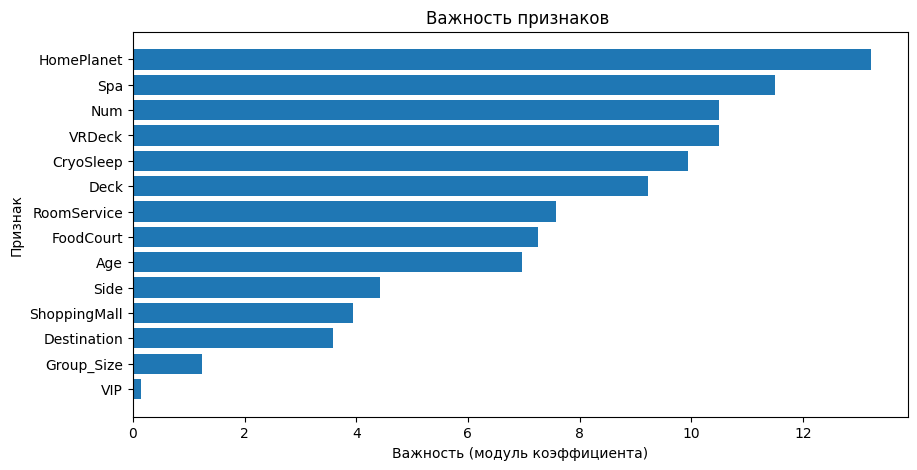

In [244]:
feature_importance = model.get_feature_importance()

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Важность (модуль коэффициента)")
plt.ylabel("Признак")
plt.title("Важность признаков ")
plt.gca().invert_yaxis()
plt.show()

Итак, в целом мы видим весьма похожую картину, как и в случае с логистической регрессией.

Видим, что прирост по метрикам есть. Хоть catboost по умолчанию работает и неплохо, но попробуем подобрать гиперпараметры.

In [33]:
params = {
    "depth": [6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "iterations": [500, 1000, 1500],
    "l2_leaf_reg": [1, 5, 10]
}

catboost = CatBoostClassifier(logging_level='Silent')
tuning_catboost = GridSearchCV(model, param_grid=params, cv=3, scoring="roc_auc", n_jobs=-1)
tuning_catboost.fit(X_train, y_train, cat_features=categorical_indices)




GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000024FD8BDE420>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [500, 1000, 1500],
                         'l2_leaf_reg': [1, 5, 10],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='roc_auc')

In [34]:
predict_proba = tuning_catboost.predict_proba(X_val)[:, 1]
predict = tuning_catboost.predict(X_val)
print_metrics(predict=predict, predict_proba=predict_proba, y_test=y_val)

{'accuracy': 0.8130787037037037, 'precision': 0.8152295632698768, 'recall': 0.8216704288939052, 'roc-auc': 0.901576650241551}


In [ ]:
# model.save_model('catboost_classifier.cbm')

Видим, что в итоге ощутимо улучшить качество не вышло, значит оставим итоговой моделью catboost c гиперпараметрами по умолчанию.

# Тестовые данные

Функция для подготовки тестовых данных:

In [ ]:
def preparing_for_test(df):
    df[[ 'CryoSleep', 'VIP']] = df[[ 'CryoSleep', 'VIP']].apply(lambda col: col.map(lambda x: 1 if x is True else (0 if x is False else x)))
    mask = (df['CryoSleep'] == 1) & (df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].isna().any(axis=1))
    df.loc[mask, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = df.loc[mask, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0)

    no_spending = (df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1) == 0)

    df.loc[df["CryoSleep"].isnull(), "CryoSleep"] = no_spending[df["CryoSleep"].isnull()].astype(int)
    df['VIP'] = df['VIP'].fillna(0.0)
    df['Age'] = df.groupby('VIP')['Age'].transform(lambda x: x.fillna(x.median()))
    df['№_of_group'], df['№_in_group'] = df['PassengerId'].apply(lambda x : x.split('_')[0]), df['PassengerId'].apply(lambda x : x.split('_')[1])
    df['HomePlanet'] = df.groupby('№_of_group')['HomePlanet'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else df['HomePlanet'].mode()[0]))

    df['Destination'] = df.groupby('№_of_group')['Destination'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else df['Destination'].mode()[0]))

    vip_spending = df.groupby("VIP")[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].max().loc[1]


    columns = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

    for col in columns:
        mean_vip = df.loc[df["VIP"] == 1, col].mean()
        median_non_vip = df.loc[df["VIP"] == 0, col].median()

        df.loc[(df["VIP"] == 1) & (df[col].isna()), col] = mean_vip
        df.loc[(df["VIP"] == 0) & (df[col].isna()), col] = median_non_vip

    df['Deck'] = df['Cabin'].str.split('/').str[0]
    df['Num'] = df['Cabin'].str.split('/').str[1]
    df['Side'] = df['Cabin'].str.split('/').str[2]

    deck_consistency = df.groupby('№_of_group')['Deck'].nunique(dropna=True)
    side_consistency = df.groupby('№_of_group')['Side'].nunique(dropna=True)
    df['Deck'] = df.groupby('№_of_group')['Deck'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else df['Deck'].mode()[0])
    )
    df['Side'] = df.groupby('№_of_group')['Side'].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else df['Side'].mode()[0])
    )

    deck_side_nums = df.groupby(['Deck', 'Side'])['Num'].apply(lambda x: x.dropna().unique()).to_dict()
    df['Num'] = df.apply(
        lambda row: row['Num'] if pd.notna(row['Num']) else np.random.choice(
            deck_side_nums.get((row['Deck'], row['Side']), ['0'])
        ),
        axis=1
    )
    pas_id = df['PassengerId']
    df['Group_Size'] = df.groupby('№_of_group')['№_in_group'].transform('count')
    df = df.drop(['Cabin', 'Name', 'PassengerId', '№_of_group', '№_in_group'], axis=1)
    df['Num'] = pd.to_numeric(df['Num'], errors='coerce')

    return pas_id, df


In [ ]:
test = pd.read_csv('test.csv')

In [ ]:
id, preparing_data = preparing_for_test(test)

In [ ]:
def get_res_to_scv(id, data, model):
    predict = model.predict(data)
    predict =  pd.Series(predict).map({1 : True, 0 : False})
    df = pd.DataFrame({'PassengerId' : id, 'Transported' : predict})
    df.to_csv('predictions.csv', index=False)

Получим submission

In [ ]:
get_res_to_scv(id, preparing_data, model)

# Рекомендации для пассажиров

Итак наконец, подводя итог, составлю рекомендации для пассажиров:

1) Выбирать правильную "HomePlanet"

Судя по графикам важности , а также статистики из тренировочных данных, планета происхождения  играет ключевую роль.

 Пассажиры с Марса и Европы имели больше шансов на успешное перемещение. Следует отправляться с них.

2) Не использовать услуги SPA и VRDeck
Пассажиры много тратящие на эти услуги чаще всего не были  перемещены.

3) Обратить внимание на номер каюты (Num) и палубу (Deck)
Пассажиры с палуб B и C были чаще успешно перемещены, чем все остальные. Следует выбирать места на этих палубах.

4) CryoSleep – очень важен для перемещения, следует пользоваться такой услугой.




